In [22]:
%matplotlib inline

import pandas as pd
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from scipy.stats import kendalltau
import numpy as np

import phate
import scanpy as sc
import meld # must be v0.2.4, run !pip install git+git://github.com/krishnaswamylab/meld.git@v0.2.4
import graphtools as gt
from scipy import sparse


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [2]:
# load adata
adata = sc.read('/home/ngr4/project/scnd/data/processed/astrocyte_210519.h5ad')

In [3]:
# MELD 
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_pcs=50)
sc.tl.umap(adata)

G = gt.Graph(data=adata.obsp['connectivities']+sparse.diags([1]*adata.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
G.knn_max = None
adata.obs['res_t']=-1
adata.obs.loc[adata.obs['timepoint']=='12wk', 'res_t'] = -0.5
adata.obs.loc[adata.obs['timepoint']=='18wk', 'res_t'] = 0
adata.obs.loc[adata.obs['timepoint']=='24wk', 'res_t'] = 0.5
adata.obs.loc[adata.obs['timepoint']=='30wk', 'res_t'] = 1
adata.obs['ees_t'] = meld.MELD().fit_transform(G=G, RES=adata.obs['res_t'])


    

        
        

In [12]:
# format data like monocle one
dt = pd.DataFrame()
dt['UMAP 1'] = adata.obsm['X_umap'][:, 0]
dt['UMAP 2'] = adata.obsm['X_umap'][:, 1]
dt['timepoint'] = adata.obs['timepoint'].to_list()
dt['Pseudotime'] = adata.obs['ees_t'].to_list()
dt['timepoint_int'] = [int(i.split('wk')[0]) for i in dt['timepoint']]


In [13]:
savefigs = True
cmap_wt = {v:sns.cubehelix_palette(5, start=0.5, rot=-0.75)[i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}


/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


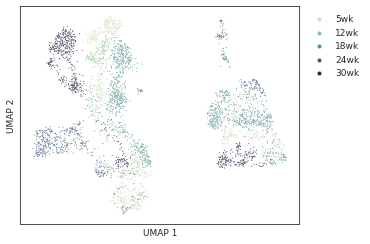

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.scatterplot(dt['UMAP 1'], dt['UMAP 2'], hue=dt['timepoint'], palette=cmap_wt, s=1, rasterized=True, ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1')
ax.legend(bbox_to_anchor=(1.01, 1))

if savefigs:
    fig.savefig('/home/ngr4/project/scnd/results/meldrevision_umap_bytimepoint.pdf', bbox_inches='tight', dpi=600)
    savefigs = False

In [15]:
savefigs = True

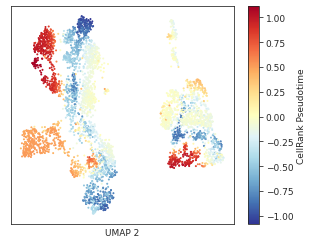

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.scatter(dt['UMAP 1'], dt['UMAP 2'], c=dt['Pseudotime'], cmap='RdYlBu_r', s=1, rasterized=True)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1')
ax.set_xlabel('UMAP 2')
cbar = fig.colorbar(im)
cbar.set_label('CellRank Pseudotime', rotation=90)
if savefigs:
    fig.savefig('/home/ngr4/project/scnd/results/meldrevisions_umap_bypseudot.pdf', bbox_inches='tight', dpi=600)
    savefigs = False

In [18]:
savefigs = True
pfp = '/home/ngr4/project/scnd/results/'

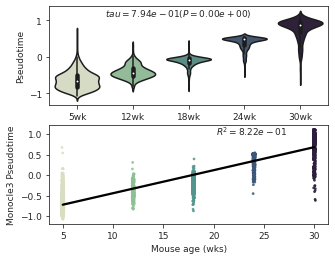

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(5, 4))
sns.violinplot(x='timepoint', y='Pseudotime', ax=ax[0], data=dt, dodge=False, hue='timepoint', palette=cmap_wt)
ax[0].set_xlabel('')
ax[0].legend().set_visible(False)
sns.regplot(x='timepoint_int', y='Pseudotime', data=dt, ax=ax[1], scatter=False, color='k')
ax[1].scatter(dt['timepoint_int']+np.random.uniform(-0.1, 0.1, size=(dt.shape[0], )),
           dt['Pseudotime'], 
           c=dt['timepoint'].map(cmap_wt), s=3, alpha=0.8, rasterized=True)
r, p_pearson = pearsonr(dt['timepoint_int'], dt['Pseudotime'])
tau, p_kendall = kendalltau(dt['timepoint_int'], dt['Pseudotime'])
R2 = r**2
ax[0].text(0.2, 0.9, '$tau={:.2e} (P={:.2e})$'.format(tau, p_kendall), transform=ax[0].transAxes, weight='bold',)
ax[1].text(0.6, 0.9, '$R^2={:.2e}$'.format(R2), transform=ax[1].transAxes, weight='bold',)
ax[1].set_ylabel('Monocle3 Pseudotime')
ax[1].set_xlabel('Mouse age (wks)')

if savefigs:
    fig.savefig(os.path.join(pfp, 'violin_scatterplot_meldpseudotVtimepoint.pdf'), dpi=600, bbox_inches='tight')
    savefigs = False

In [20]:
savefigs = True

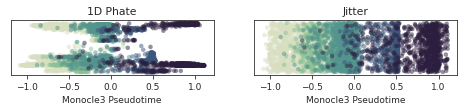

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8,1))
sns.scatterplot(x=dt['Pseudotime'], y=adata.obsm['1dphate'].squeeze(), hue=adata.obs['timepoint'].to_list(), palette=cmap_wt,
                s=20, alpha=0.5, linewidth=0, ax=ax[0], rasterized=True)
ax[0].set_xlabel('Monocle3 Pseudotime')
ax[0].set_yticks([])
ax[0].legend().set_visible(False)
ax[0].set_title('1D Phate')

sns.scatterplot(x=dt['Pseudotime'], y=np.random.uniform(-1, 1, size=(dt.shape[0],)), hue=adata.obs['timepoint'].to_list(), palette=cmap_wt,
                s=20, alpha=0.5, linewidth=0, ax=ax[1], rasterized=True)
ax[1].set_xlabel('Monocle3 Pseudotime')
ax[1].set_yticks([])
ax[1].legend().set_visible(False)
ax[1].set_title('Jitter')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatterplots_phateVmeldpseudot.pdf'), dpi=600, bbox_inches='tight')
    savefigs = False